# Capital Cost of Compression

### Imports

In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator

import requests
from io import BytesIO

### Auxiliary Functions

In [38]:
def compression_power_stage(cp, m, r, t_in, M, eta_is, cr, z):
    """
    Compression Power Requirement (for each stage).
    """

    # Relationship between Specific Heat (Coefficient of Adiabatic Expansion, i.e., Cp/Cv)
    k = cp / z

    w_stage = (
        (1000 / (24 * 3600))
        * (m * z * r * t_in / (M * eta_is))
        * (k / (k - 1))
        * (cr ** (((k - 1) / k)) - 1)
    )

    return k, w_stage


def get_ylim(y_min, y_max):
    delta = 0.25 * (y_max - y_min)
    return (y_min - delta, y_max + delta)


def config_plot(ax, y_values, x_lim, title, leg_loc="upper right", x_multiplelocator=2):
    y_min, y_max = min(y_values), max(y_values)
    y_min_lim, y_max_lim = get_ylim(y_min, y_max)
    y_baseline = np.mean([y_min, y_min_lim])
    ax.set_ylim([y_min_lim, y_max_lim])

    ax.xaxis.set_major_locator(MultipleLocator(x_multiplelocator))
    ax.set_xlim(x_lim)

    # ax.grid(color="w", axis="y")
    ax.grid(axis="y", alpha=0.1)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(loc=leg_loc, fontsize="small")
    ax.set_title(title)

### Data Reading

In [39]:
# URL = "https://raw.githubusercontent.com/thiagoneye/costcaster/main/data/Forecast%20(MtCO2e).xlsx"
# response = requests.get(URL)

# df = pd.read_excel(BytesIO(response.content), engine="openpyxl")

df = pd.read_excel("../data/Forecast (MtCO2e).xlsx")

df.drop(columns="Unnamed: 0", inplace=True)
df.set_index("Years", inplace=True)

display(df)

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,1.341908,1.252185,1.320980,1.579306,1.519020,1.554676,13.513428,13.340975,13.302679,2.283988,2.074743,2.248368,23.632865,18.060261,23.264298,8.940516,9.801581,8.801084
2026,1.341908,1.242492,1.300379,1.579306,1.519730,1.530430,13.513428,13.317894,13.095216,2.283988,1.921093,2.213303,23.632865,17.756772,22.901478,8.940516,9.772826,8.663826
2027,1.341908,1.239475,1.280099,1.579306,1.519925,1.506562,13.513428,13.317618,12.890989,2.283988,1.776351,2.178785,23.632865,17.540634,22.544317,8.940516,9.788235,8.528709
2028,1.341908,1.238880,1.260135,1.579306,1.519972,1.483066,13.513428,13.319519,12.689947,2.283988,1.657053,2.144806,23.632865,17.448469,22.192726,8.940516,9.823698,8.395699
2029,1.341908,1.238803,1.240482,1.579306,1.519983,1.459937,13.513428,13.319376,12.492040,2.283988,1.569028,2.111357,23.632865,17.423024,21.846618,8.940516,9.856964,8.264763
2030,1.341908,1.238796,1.221136,1.579306,1.519985,1.437168,13.513428,13.318683,12.297220,2.283988,1.510201,2.078429,23.632865,17.418340,21.505907,8.940516,9.878516,8.135870


### Variables

In [40]:
p_initial = 0.1  # MPa
p_final = 15  # MPa
p_cutoff = 7.38  # MPa
n_stage = 4
M = 44.01  # kg/kmol
r = 8.314  # [kJ/kmol*K]
t_in = 313.15  # K
eta_is = 0.82
m = 25000
rho = 630
np_ = 0.75
dt = 356  # Temperature Variation During Compression

crf = 0.1275
oem = 0.05
p_e = 0.082
cf = 0.8

z1 = 0.995
z2 = 0.986
z3 = 0.959
z4 = 0.875

list_of_companies = ["A-1", "C-1", "C-2", "P-1", "S-1", "S-2"]

COLORS = {
    "History": mcolors.CSS4_COLORS["darkslategray"],
    "Reference": mcolors.CSS4_COLORS["mediumturquoise"],
    "DBM": mcolors.CSS4_COLORS["goldenrod"],
    "GBM": mcolors.CSS4_COLORS["mediumseagreen"],
    "BAU": mcolors.CSS4_COLORS["indianred"],
}

### Analysis

In [41]:
cr = (p_cutoff / p_initial) ** (1 / n_stage)

cv = (13.946 + (5.981e-2 * dt) - (3.501e-5 * dt**2) + (7.469e-9 * dt**3)) / 44.01
cp = (22.26 + (5.981e-2 * dt) - (3.501e-5 * dt**2) + (7.469e-9 * dt**3)) / (44.01 * cv)

# Compression Power Requirement (for each stage)

k1, w_stage1 = compression_power_stage(cp, m, r, t_in, M, eta_is, cr, z=z1)
k2, w_stage2 = compression_power_stage(cp, m, r, t_in, M, eta_is, cr, z=z2)
k3, w_stage3 = compression_power_stage(cp, m, r, t_in, M, eta_is, cr, z=z3)
k4, w_stage4 = compression_power_stage(cp, m, r, t_in, M, eta_is, cr, z=z4)

# Convertion to tCO2e

df = df * 1e6

# Carbon Capture Percentage

df_ccp = df.copy()
df_ccp = df_ccp * 0.76

display(df_ccp)

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,1019850.08,951660.340586,1.003945e+06,1.200273e+06,1.154455e+06,1.181554e+06,1.027021e+07,1.013914e+07,1.011004e+07,1735830.614,1.576805e+06,1.708759e+06,1.796098e+07,1.372580e+07,1.768087e+07,6.794792e+06,7.449201e+06,6.688824e+06
2026,1019850.08,944294.226551,9.882879e+05,1.200273e+06,1.154995e+06,1.163127e+06,1.027021e+07,1.012160e+07,9.952364e+06,1735830.614,1.460031e+06,1.682110e+06,1.796098e+07,1.349515e+07,1.740512e+07,6.794792e+06,7.427348e+06,6.584508e+06
2027,1019850.08,942001.377351,9.728750e+05,1.200273e+06,1.155143e+06,1.144987e+06,1.027021e+07,1.012139e+07,9.797152e+06,1735830.614,1.350027e+06,1.655877e+06,1.796098e+07,1.333088e+07,1.713368e+07,6.794792e+06,7.439059e+06,6.481819e+06
2028,1019850.08,941548.854033,9.577024e+05,1.200273e+06,1.155179e+06,1.127130e+06,1.027021e+07,1.012283e+07,9.644360e+06,1735830.614,1.259360e+06,1.630053e+06,1.796098e+07,1.326084e+07,1.686647e+07,6.794792e+06,7.466011e+06,6.380731e+06
2029,1019850.08,941490.079546,9.427665e+05,1.200273e+06,1.155187e+06,1.109552e+06,1.027021e+07,1.012273e+07,9.493950e+06,1735830.614,1.192461e+06,1.604631e+06,1.796098e+07,1.324150e+07,1.660343e+07,6.794792e+06,7.491293e+06,6.281220e+06
2030,1019850.08,941484.970838,9.280636e+05,1.200273e+06,1.155188e+06,1.092248e+06,1.027021e+07,1.012220e+07,9.345887e+06,1735830.614,1.147753e+06,1.579606e+06,1.796098e+07,1.323794e+07,1.634449e+07,6.794792e+06,7.507672e+06,6.183261e+06


### Power Requirement

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,10989.364027,10254.587530,10817.978779,12933.501309,12439.796248,12731.796158,110666.291553,109254.007915,108940.389149,18704.390852,16990.813507,18412.685467,193537.977356,147901.927347,190519.644892,73217.079975,80268.644606,72075.218866
2026,10989.364027,10175.214189,10649.266380,12933.501309,12445.612185,12533.236711,110666.291553,109064.995228,107241.403152,18704.390852,15732.516824,18125.529391,193537.977356,145416.552717,187548.385002,73217.079975,80033.165265,70951.165717
2027,10989.364027,10150.507661,10483.185144,12933.501309,12447.206034,12337.773910,110666.291553,109062.732471,105568.913788,18704.390852,14547.174568,17842.851672,193537.977356,143646.515964,184623.463563,73217.079975,80159.354390,69844.642801
2028,10989.364027,10145.631509,10319.694038,12933.501309,12447.596031,12145.359460,110666.291553,109078.298094,103922.507826,18704.390852,13570.200711,17564.582471,193537.977356,142891.743624,181744.157902,73217.079975,80449.776668,68755.376727
2029,10989.364027,10144.998187,10158.752666,12933.501309,12447.680830,11955.945820,110666.291553,109077.130060,102301.778482,18704.390852,12849.328524,17290.653032,193537.977356,142683.366133,178909.756616,73217.079975,80722.201998,67683.098363
2030,10989.364027,10144.943138,10000.321265,12933.501309,12447.697046,11769.486191,110666.291553,109071.456572,100706.325314,18704.390852,12367.576075,17020.995675,193537.977356,142645.009430,176119.559394,73217.079975,80898.694355,66627.542777


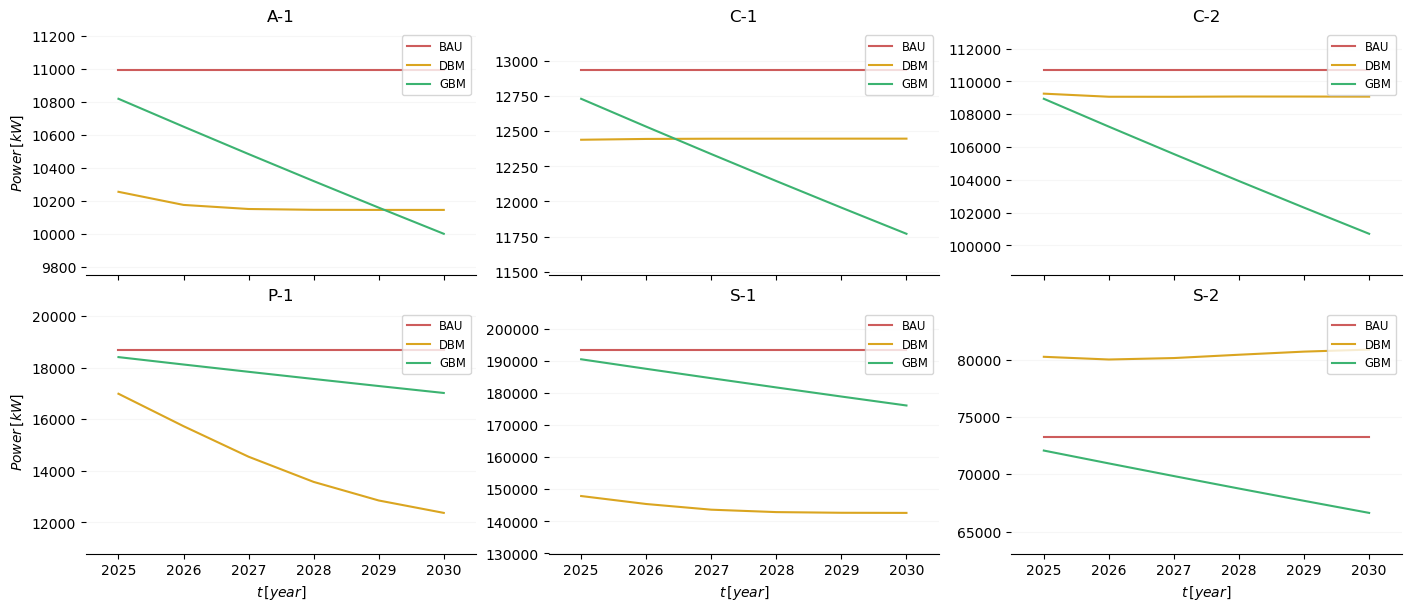

In [42]:
# Power Requirement [kW]

df_pr = (
    (1000 / (24 * 3600))
    * (df_ccp / 365)
    * (r * t_in / (M * eta_is))
    * (
        z1 * (k1 / (k1 - 1)) * (cr ** ((k1 - 1) / k1) - 1)
        + (z2 + z3) * (k3 / (k3 - 1)) * (cr ** ((k3 - 1) / k3) - 1)
        + z4 * (k4 / (k4 - 1)) * (cr ** ((k4 - 1) / k4) - 1)
    )
)
display(df_pr)

# Plot

fig, axs = plt.subplots(2, 3, figsize=(14, 6), constrained_layout=True, sharex=True)
axs = axs.flatten()

for company_id, company_name in enumerate(list_of_companies):
    ax = axs[company_id]
    X = df_pr.index.values
    y_values = None

    # BAU
    column_name = f"{company_name} - BAU"
    data = df_pr.loc[:, column_name].values
    y_values = data
    ax.plot(X, data, color=COLORS["BAU"], label="BAU")

    # DBM
    column_name = f"{company_name} - DBM"
    data = df_pr.loc[:, column_name].values
    y_values = np.concatenate((y_values, data))
    ax.plot(X, data, color=COLORS["DBM"], label="DBM")

    # GBM
    column_name = f"{company_name} - GBM"
    data = df_pr.loc[:, column_name].values
    y_values = np.concatenate((y_values, data))
    ax.plot(X, data, color=COLORS["GBM"], label="GBM")

    config_plot(
        ax,
        y_values,
        x_lim=[2025 - 0.5, 2031 - 0.5],
        title=company_name,
        x_multiplelocator=1,
    )

    if company_id in [0, 3]:
        ax.set_ylabel("$Power \\, [kW]$")

    if company_id >= 3:
        ax.set_xlabel("$t \\, [year]$")

### Capital Cost of Compression

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,5.171776e+07,5.031137e+07,5.139490e+07,5.518552e+07,5.433637e+07,5.484099e+07,1.969912e+08,1.959851e+08,1.957606e+08,6.392486e+07,6.152353e+07,6.352571e+07,3.734597e+08,2.821971e+08,3.711270e+08,1.670827e+08,1.733202e+08,1.660391e+08
2026,5.171776e+07,5.015586e+07,5.107406e+07,5.518552e+07,5.434649e+07,5.449862e+07,1.969912e+08,1.958499e+08,1.945378e+08,6.392486e+07,5.966587e+07,6.312905e+07,3.734597e+08,2.802971e+08,3.688088e+08,1.670827e+08,1.731173e+08,1.650021e+08
2027,5.171776e+07,5.010731e+07,5.075523e+07,5.518552e+07,5.434926e+07,5.415838e+07,1.969912e+08,1.958483e+08,1.933226e+08,6.392486e+07,5.783232e+07,6.273487e+07,3.734597e+08,2.789319e+08,3.665051e+08,1.670827e+08,1.732261e+08,1.639715e+08
2028,5.171776e+07,5.009772e+07,5.043838e+07,5.518552e+07,5.434994e+07,5.382027e+07,1.969912e+08,1.958594e+08,1.921150e+08,6.392486e+07,5.625234e+07,6.234316e+07,3.734597e+08,2.783468e+08,3.642158e+08,1.670827e+08,1.734760e+08,1.629474e+08
2029,5.171776e+07,5.009647e+07,5.012352e+07,5.518552e+07,5.435009e+07,5.348427e+07,1.969912e+08,1.958586e+08,1.909149e+08,6.392486e+07,5.504215e+07,6.195389e+07,3.734597e+08,2.781849e+08,3.044427e+08,1.670827e+08,1.737099e+08,1.619297e+08
2030,5.171776e+07,5.009636e+07,4.981063e+07,5.518552e+07,5.435012e+07,5.315037e+07,1.969912e+08,1.958545e+08,1.897224e+08,6.392486e+07,5.421046e+07,6.156706e+07,3.734597e+08,2.781551e+08,3.025409e+08,1.670827e+08,1.738612e+08,1.609184e+08


,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,4706.164971,4906.230283,4750.878412,4266.866568,4367.946781,4307.404325,1780.046893,1793.848281,1796.951920,3417.639229,3620.987885,3450.105484,1929.645724,1908.001431,1947.972087,2282.017788,2159.251534,2303.692238
2026,4706.164971,4929.219312,4796.016883,4266.866568,4366.718745,4348.327398,1780.046893,1795.717080,1814.017558,3417.639229,3792.518899,3482.880298,1929.645724,1927.545696,1966.472572,2282.017788,2163.069974,2325.572638
2027,4706.164971,4936.433822,4841.584425,4266.866568,4366.382364,4389.639451,1780.046893,1795.739484,1831.245334,3417.639229,3975.501760,3515.966603,1929.645724,1941.794043,1985.148834,2282.017788,2161.021507,2347.660946
2028,4706.164971,4937.861023,4887.585120,4266.866568,4366.300066,4431.344184,1780.046893,1795.585383,1848.636790,3417.639229,4145.284230,3549.367362,1929.645724,1947.955609,2004.002545,2282.017788,2156.326554,2369.959138
2029,4706.164971,4938.046471,4934.023088,4266.866568,4366.282172,4473.445331,1780.046893,1795.596945,1866.193481,3417.639229,4283.659266,3583.085566,1929.645724,1949.665884,1701.655336,2282.017788,2151.947148,2392.469211
2030,4706.164971,4938.062591,4980.902487,4266.866568,4366.278750,4515.946663,1780.046893,1795.653110,1883.916978,3417.639229,4383.273086,3617.124232,1929.645724,1949.981136,1717.815588,2282.017788,2149.122538,2415.193177


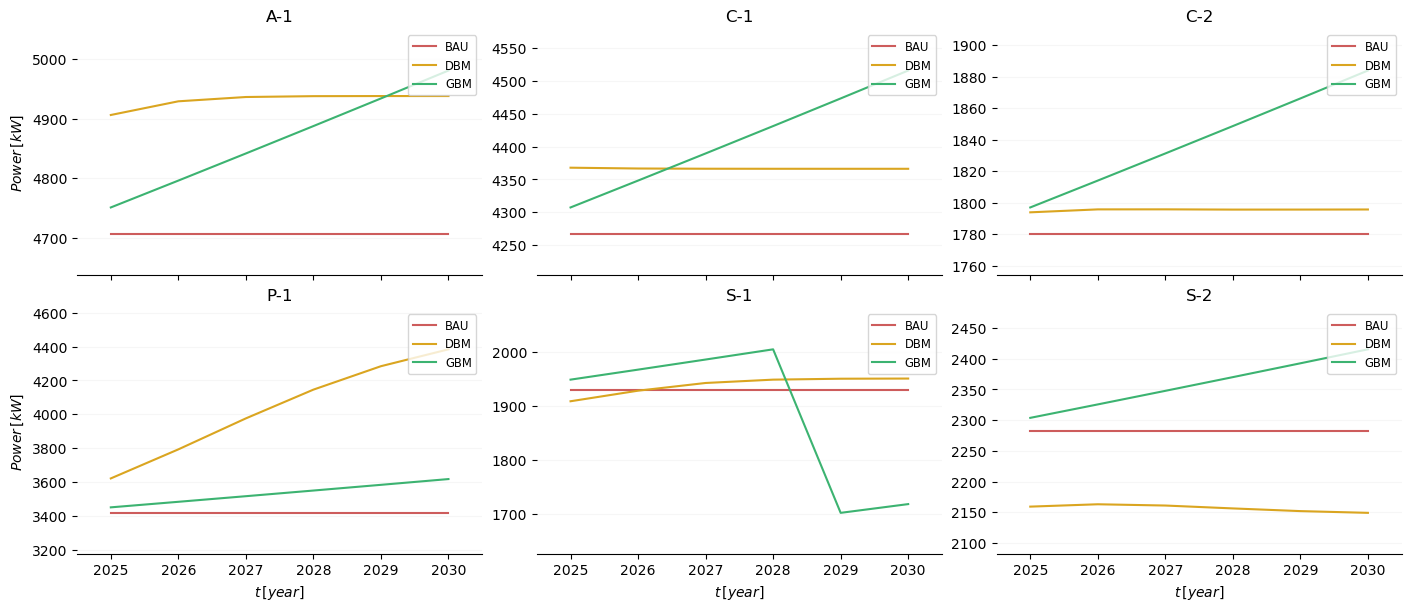

In [43]:
# Capital Cost of Compression ($)

repeated_term = (1000 * df_ccp / 365) / (24 * 3600 * np.ceil(df_pr / 60000))
df_ccc = (
    ((1000 * df_ccp / 365) / (24 * 3600))
    * (
        (0.13 * (10**6) / (repeated_term**0.71))
        + (1.4 * (10**6) * np.log(p_cutoff / p_initial) / (repeated_term**0.6))
    )
    * 2.107
)
display(df_ccc)

# Capital Cost of Compression ($/kW)

df_ccc = df_ccc/df_pr
display(df_ccc)

# Plot

fig, axs = plt.subplots(2, 3, figsize=(14, 6), constrained_layout=True, sharex=True)
axs = axs.flatten()

for company_id, company_name in enumerate(list_of_companies):
    ax = axs[company_id]
    X = df_ccc.index.values
    y_values = None

    # BAU
    column_name = f"{company_name} - BAU"
    data = df_ccc.loc[:, column_name].values
    y_values = data
    ax.plot(X, data, color=COLORS["BAU"], label="BAU")

    # DBM
    column_name = f"{company_name} - DBM"
    data = df_ccc.loc[:, column_name].values
    y_values = np.concatenate((y_values, data))
    ax.plot(X, data, color=COLORS["DBM"], label="DBM")

    # GBM
    column_name = f"{company_name} - GBM"
    data = df_ccc.loc[:, column_name].values
    y_values = np.concatenate((y_values, data))
    ax.plot(X, data, color=COLORS["GBM"], label="GBM")

    config_plot(
        ax,
        y_values,
        x_lim=[2025 - 0.5, 2031 - 0.5],
        title=company_name,
        x_multiplelocator=1,
    )

    if company_id in [0, 3]:
        ax.set_ylabel("$Power \\, [kW]$")

    if company_id >= 3:
        ax.set_xlabel("$t \\, [year]$")

### Annual Compression Capital Cost

In [44]:
# Annual Compression Capital Cost ($)

# Total Annual Compression Cost ($)

# Plot